### ECE 579- Intelligent Systems
### Project Title - Smart Garbage Segregation
### Winter 2025



# Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import urllib
import itertools
import random, os, glob
from imutils import paths
from sklearn.utils import shuffle
from urllib.request import urlopen

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import  ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

# Import Dataset

In [2]:
dir_path = "/Users/shubhigupta/Desktop/Garbage Segregation/Smart-Garbage-Segregation-main/Dataset"

In [3]:
target_size = (224, 224)
waste_labels = {"cardboard":0, "glass":1, "metal":2, "paper":3, "plastic":4, "trash":5}

In [4]:
def load_dataset(path):
  x = []
  labels = []
  image_paths = sorted(list(paths.list_images(path)))
  for image_path in image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    x.append(img)
    label = image_path.split(os.path.sep)[-2]
    labels.append(waste_labels[label])
  x, labels = shuffle(x, labels, random_state=42)
  input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
  print("X shape: ", np.array(x).shape)
  print(f"Number of Labels: {len(np.unique(labels))} , Number of Observation: {len(labels)}")
  print("Input Shape: ", input_shape)
  return x, labels, input_shape

In [5]:
x, labels, input_shape = load_dataset(dir_path)

X shape:  (2527, 224, 224, 3)
Number of Labels: 6 , Number of Observation: 2527
Input Shape:  (224, 224, 3)


# Visulization Image

In [24]:
def visualizeation_img(image_batch, labels, num_of_img):
  plt.figure(figsize=(10,10))
  for n in range(num_of_img):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=len(np.unique(labels)))[n] == 1][0].title())
    plt.axis("off")

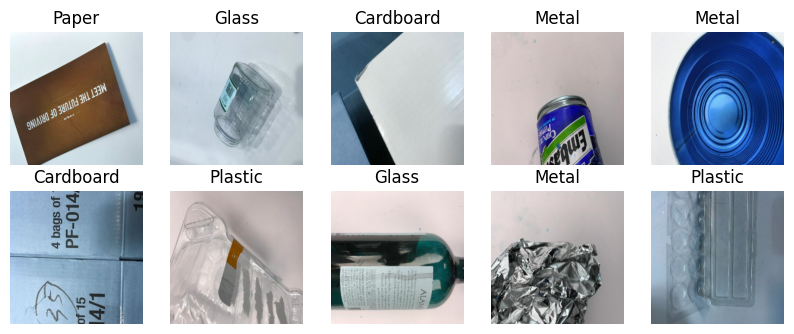

In [25]:
visualizeation_img(x, labels, 10)

In [6]:
# def CNN_data_preparation():
#   train = ImageDataGenerator(horizontal_flip=True,
#                              vertical_flip=True,
#                              validation_split=0.1,
#                              rescale=1./255,
#                              shear_range=0.1,
#                              zoom_range=0.1,
#                              width_shift_range=0.1,
#                              height_shift_range=0.1)
#   test = ImageDataGenerator(rescale=1/255, validation_split=0.1)
#   train_generator = train.flow_from_directory(directory=dir_path,
#                                               target_size=(target_size),
#                                               class_mode="categorical",
#                                               subset="training")
#   test_generator = test.flow_from_directory(directory=dir_path,
#                                             target_size=(target_size),
#                                             batch_size=251,
#                                             class_mode="categorical",
#                                             subset="validation")
#   return train_generator, test_generator
from sklearn.model_selection import train_test_split
def split_data(x, labels):
    # First split: Train + Val and Test (90% - 10%)
    x_train_val, x_test, y_train_val, y_test = train_test_split(x, labels, test_size=0.1, random_state=42, stratify=labels)

    # Second split: Train and Val (from Train + Val) → 90% train, 10% val of total
    x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.1/0.9, random_state=42, stratify=y_train_val)

    print(f"Train: {len(x_train)}, Validation: {len(x_val)}, Test: {len(x_test)}")
    return x_train, x_val, x_test, y_train, y_val, y_test

In [7]:
# train_generator, test_generator = CNN_data_preparation()

x_train, x_val, x_test, y_train, y_val, y_test = split_data(x, labels)

Train: 2021, Validation: 253, Test: 253


# Modeling

In [14]:
# def CNN_create_and_fit_model(train_generator, test_generator, summary=True, fit=True, epochs=100):
#   model = Sequential()

#   model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", input_shape=(input_shape), activation="relu"))
#   model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

#   model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
#   model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

#   model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
#   model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

#   model.add(Flatten())

#   model.add(Dense(units=64, activation="relu"))
#   model.add(Dropout(rate=0.2))

#   model.add(Dense(units=32, activation="relu"))
#   model.add(Dropout(rate=0.2))

#   model.add(Dense(units=6, activation="softmax"))

#   model.compile(loss="categorical_crossentropy",
#                 optimizer="adam",
#                 metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

#   callbacks = [EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min"), 
#               ModelCheckpoint(filepath="mymodel1.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)]
  
#   if summary:
#     model.summary()
  
#   if fit:
#     history = model.fit(train_generator, epochs=epochs, validation_data=test_generator, 
#                     callbacks=callbacks,steps_per_epoch=10, validation_steps=251//32)
#  # steps_per_epoch=2276//32, validation_steps=251//32
#                                                                                                               # you can choose 2276/32 is 71 per epoch for best accuracy

#   return model, history

def CNN_create_and_fit_model(x_train, x_val, x_test, y_train, y_val, y_test, summary=True, fit=True, epochs=100, batch_size=32):
    model = Sequential()

    # Model architecture
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=(x_train.shape[1], x_train.shape[2], 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=2, strides=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=2, strides=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=2, strides=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=64, activation="relu"))
    model.add(Dropout(rate=0.2))

    model.add(Dense(units=32, activation="relu"))
    model.add(Dropout(rate=0.2))

    model.add(Dense(units=6, activation="softmax"))

    # Compile the model
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

    # Callbacks
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min"), 
        ModelCheckpoint(filepath="mymodel1.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)
    ]

    if summary:
        model.summary()

    # Train the model
    if fit:
        history = model.fit(
            x_train, y_train,  # Training data and labels
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),  # Validation data and labels
            callbacks=callbacks,
            steps_per_epoch=len(x_train) // batch_size,
            validation_steps=len(x_val) // batch_size
        )

    return model, history


In [8]:
import numpy as np
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

def CNN_create_and_fit_model(x_train, x_val, x_test, y_train, y_val, y_test, summary=True, fit=True, epochs=100, batch_size=32):
    model = Sequential()

    # Model architecture
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=(x_train.shape[1], x_train.shape[2], 3), activation="relu"))
    model.add(MaxPooling2D(pool_size=2, strides=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=2, strides=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=2, strides=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=64, activation="relu"))
    model.add(Dropout(rate=0.2))

    model.add(Dense(units=32, activation="relu"))
    model.add(Dropout(rate=0.2))

    model.add(Dense(units=6, activation="softmax"))

    # Compile the model
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])

    # Callbacks
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=50, verbose=1, mode="min"), 
        ModelCheckpoint(filepath="mymodel1.h5", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=False, verbose=1)
    ]

    if summary:
        model.summary()

    # Train the model
    if fit:
        history = model.fit(
            x_train, y_train,  # Training data and labels
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),  # Validation data and labels
            callbacks=callbacks,
            steps_per_epoch=len(x_train) // batch_size,
            validation_steps=len(x_val) // batch_size
        )

    return model, history

# Normalize image data (ensure data is in float32 format to avoid overflow during normalization)
x_train = np.array(x_train, dtype=np.float32) / 255.0
x_val = np.array(x_val, dtype=np.float32) / 255.0
x_test = np.array(x_test, dtype=np.float32) / 255.0

# Ensure labels are one-hot encoded
y_train = to_categorical(y_train, num_classes=6)  # Change num_classes to the actual number of classes
y_val = to_categorical(y_val, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

# Now train the model
model, history = CNN_create_and_fit_model(x_train, x_val, x_test, y_train, y_val, y_test)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,645,830 (6.28 MB)

 Trainable params: 1,645,830 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - acc: 0.2429 - loss: 1.7457 - precision: 0.6272 - recall: 0.0081
Epoch 1: val_loss improved from inf to 1.56067, saving model to mymodel1.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 424ms/step - acc: 0.2434 - loss: 1.7445 - precision: 0.6285 - recall: 0.0084 - val_acc: 0.3571 - val_loss: 1.5607 - val_precision: 0.7600 - val_recall: 0.0848
Epoch 2/100
 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - acc: 0.2000 - loss: 1.8375 - precision: 1.0000 - recall: 0.2000
Epoch 2: val_loss did not improve from 1.56067
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.2000 - loss: 1.8375 - precision: 1.0000 - recall: 0.2000 - val_acc: 0.3080 - val_loss: 1.5898 - val_precision: 0.6486 - val_recall: 0.1071
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - acc: 0.3552 - loss: 1.5499 - precision: 0.7083 - recall: 0.0800
Epoch 3: val_loss improved from 1.56067 to 1.39665, saving model to mymodel1.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 451ms/step - acc: 0.3556 - loss: 1.5489 - precision: 0.7091 - recall: 0.0805 - val_acc: 0.4330 - val_loss: 1.3967 - val_precision: 0.6842 - val_recall: 0.1741
Epoch 4/100
 1/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - acc: 0.2000 - loss: 2.2782 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4: val_loss did not improve from 1.39665
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.2000 - loss: 2.2782 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_acc: 0.3259 - val_loss: 1.5074 - val_precision: 0.4935 - val_recall: 0.1696
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - acc: 0.3831 - loss: 1.4529 - precision: 0.6277 - recall: 0.1355
Epoch 5: val_loss improved from 1.39665 to 1.35620, saving model to mymodel1.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 523ms/step - acc: 0.3837 - loss: 1.4519 - precision: 0.6284 - recall: 0.1361 - val_acc: 0.4821 - val_loss: 1.3562 - val_precision: 0.7600 - val_recall: 0.1696
Epoch 6/100
 1/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - acc: 0.2000 - loss: 1.5223 - precision: 1.0000 - recall: 0.2000
Epoch 6: val_loss improved from 1.35620 to 1.34218, saving model to mymodel1.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.2000 - loss: 1.5223 - precision: 1.0000 - recall: 0.2000 - val_acc: 0.5134 - val_loss: 1.3422 - val_precision: 0.7600 - val_recall: 0.1696
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - acc: 0.5203 - loss: 1.2567 - precision: 0.7472 - recall: 0.2500
Epoch 7: val_loss improved from 1.34218 to 1.27717, saving model to mymodel1.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 484ms/step - acc: 0.5203 - loss: 1.2564 - precision: 0.7468 - recall: 0.2505 - val_acc: 0.5670 - val_loss: 1.2772 - val_precision: 0.7812 - val_recall: 0.2232
Epoch 8/100
 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - acc: 0.2000 - loss: 1.6319 - precision: 1.0000 - recall: 0.2000
Epoch 8: val_loss did not improve from 1.27717
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.2000 - loss: 1.6319 - precision: 1.0000 - recall: 0.2000 - val_acc: 0.5625 - val_loss: 1.2844 - val_precision: 0.7812 - val_recall: 0.2232
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - acc: 0.5638 - loss: 1.1460 - precision: 0.7800 - recall: 0.3350
Epoch 9: val_loss improved from 1.27717 to 1.24305, saving model to mymodel1.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 509ms/step - acc: 0.5637 - loss: 1.1463 - precision: 0.7796 - recall: 0.3351 - val_acc: 0.5357 - val_loss: 1.2431 - val_precision: 0.7358 - val_recall: 0.3482
Epoch 10/100
 1/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - acc: 0.8000 - loss: 0.5422 - precision: 1.0000 - recall: 0.8000
Epoch 10: val_loss did not improve from 1.24305
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - acc: 0.8000 - loss: 0.5422 - precision: 1.0000 - recall: 0.8000 - val_acc: 0.5268 - val_loss: 1.2759 - val_precision: 0.7182 - val_recall: 0.3527
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - acc: 0.6163 - loss: 1.0308 - precision: 0.7710 - recall: 0.4298
Epoch 11: val_loss did not improve from 1.24305
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 595ms/step - acc: 0.6165 - loss: 1.0305 - precision: 0.7713 - recall: 0.4300 - val_acc: 0.5625 - val_loss: 1.2476 - val_precision: 0.7230 - val_recall: 0.4777
Epoch 12/100
 1/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - acc: 0.6000 - loss: 0.7437 - precision: 1.

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 505ms/step - acc: 0.6545 - loss: 0.9419 - precision: 0.8012 - recall: 0.4961 - val_acc: 0.5402 - val_loss: 1.2181 - val_precision: 0.7287 - val_recall: 0.4196
Epoch 14/100
 1/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - acc: 0.6000 - loss: 0.8476 - precision: 0.7500 - recall: 0.6000
Epoch 14: val_loss improved from 1.21815 to 1.19092, saving model to mymodel1.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.6000 - loss: 0.8476 - precision: 0.7500 - recall: 0.6000 - val_acc: 0.5536 - val_loss: 1.1909 - val_precision: 0.7463 - val_recall: 0.4464
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - acc: 0.6986 - loss: 0.8447 - precision: 0.8207 - recall: 0.5394
Epoch 15: val_loss improved from 1.19092 to 1.18871, saving model to mymodel1.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 503ms/step - acc: 0.6983 - loss: 0.8449 - precision: 0.8205 - recall: 0.5394 - val_acc: 0.6205 - val_loss: 1.1887 - val_precision: 0.7290 - val_recall: 0.5045
Epoch 16/100
 1/63 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - acc: 0.6000 - loss: 1.0615 - precision: 0.6000 - recall: 0.6000
Epoch 16: val_loss did not improve from 1.18871
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.6000 - loss: 1.0615 - precision: 0.6000 - recall: 0.6000 - val_acc: 0.5670 - val_loss: 1.2378 - val_precision: 0.6962 - val_recall: 0.4911
Epoch 17/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - acc: 0.6804 - loss: 0.8318 - precision: 0.7981 - recall: 0.5572
Epoch 17: val_loss did not improve from 1.18871
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 517ms/step - acc: 0.6806 - loss: 0.8315 - precision: 0.7983 - recall: 0.5573 - val_acc: 0.5938 - val_loss: 1.2691 - val_precision: 0.6705 - val_recall: 0.5268
Epoch 18/100
 1/63 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - acc: 0.8000 - loss: 0.4359 - precision: 0.

63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - acc: 0.7556 - loss: 0.6886 - precision: 0.8402 - recall: 0.6501 - val_acc: 0.6295 - val_loss: 1.1680 - val_precision: 0.7308 - val_recall: 0.5089
Epoch 20/100
 1/63 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - acc: 1.0000 - loss: 0.4502 - precision: 1.0000 - recall: 0.8000
Epoch 20: val_loss did not improve from 1.16804
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 1.0000 - loss: 0.4502 - precision: 1.0000 - recall: 0.8000 - val_acc: 0.6250 - val_loss: 1.1811 - val_precision: 0.7134 - val_recall: 0.5223
Epoch 21/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - acc: 0.7849 - loss: 0.6123 - precision: 0.8653 - recall: 0.6846
Epoch 21: val_loss did not improve from 1.16804
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 504ms/step - acc: 0.7847 - loss: 0.6124 - precision: 0.8652 - recall: 0.6846 - val_acc: 0.5759 - val_loss: 1.3738 - val_precision: 0.6708 - val_recall: 0.4821
Epoch 22/100
 1/63 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - acc: 1.0000 - loss: 0.4096 - precision: 1.

# Evaluation

In [13]:
# def CNN_model_evaluate(model):
#   loss, precision, recall, acc = model.evaluate(test_generator, batch_size=32)
#   print("Test Accuracy: %.2f" % (100 * acc))
#   print("Test Loss: %.2f" % (100 * loss))
#   print("Test Precision: %.2f" % (100 * precision))
#   print("Test Recall: %.2f" % (100 * recall))

#   X_test, y_test = next(test_generator)
#   y_pred = model.predict(X_test)
#   y_pred = np.argmax(y_pred, axis=1)
#   y_test = np.argmax(y_test, axis=1)
#   target_names = list(waste_labels.keys())
#   print(classification_report(y_test, y_pred, target_names=target_names))

#   plt.figure(figsize=(20,5))
#   plt.subplot(1,2,1)
#   plt.plot(history.history["acc"], color="r", label="Training Accuracy")
#   plt.plot(history.history["val_acc"], color="b", label="Validation Accuracy")
#   plt.legend(loc="lower right")
#   plt.xlabel("Epoch", fontsize=16)
#   plt.ylabel("Accuracy", fontsize=16)
#   plt.ylim([min(plt.ylim()),1])
#   plt.title("Training and Validation Accuracy", fontsize=16)

#   plt.subplot(1,2,2)
#   plt.plot(history.history["loss"], color="r", label="Training Loss")
#   plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
#   plt.legend(loc="upper right")
#   plt.xlabel("Epoch", fontsize=16)
#   plt.ylabel("Loss", fontsize=16)
#   plt.ylim([0, max(plt.ylim())])
#   plt.title("Training and Validation Loss", fontsize=16)

#   return y_test, y_pred

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

def CNN_model_evaluate(model, x_test, y_test, history, waste_labels):
    # Evaluate model
    loss, precision, recall, acc = model.evaluate(x_test, y_test, batch_size=32)
    print("Test Accuracy: %.2f%%" % (100 * acc))
    print("Test Loss: %.2f" % loss)
    print("Test Precision: %.2f%%" % (100 * precision))
    print("Test Recall: %.2f%%" % (100 * recall))

    # Predict
    y_pred_probs = model.predict(x_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification Report
    target_names = [str(label) for label in waste_labels.values()]

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=target_names))

    # Plot Accuracy and Loss
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["acc"], color="r", label="Training Accuracy")
    plt.plot(history.history["val_acc"], color="b", label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.ylim([0, 1])
    plt.title("Training and Validation Accuracy", fontsize=16)

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], color="r", label="Training Loss")
    plt.plot(history.history["val_loss"], color="b", label="Validation Loss")
    plt.legend(loc="upper right")
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.ylim([0, max(max(history.history["loss"]), max(history.history["val_loss"]))])
    plt.title("Training and Validation Loss", fontsize=16)

    plt.tight_layout()
    plt.show()

    return y_true, y_pred


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - acc: 0.6351 - loss: 1.9048 - precision: 0.6588 - recall: 0.6206
Test Accuracy: 60.87%
Test Loss: 2.24
Test Precision: 63.98%
Test Recall: 59.68%
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.60      0.67        40
           1       0.51      0.72      0.60        50
           2       0.50      0.66      0.57        41
           3       0.78      0.77      0.77        60
           4       0.57      0.42      0.48        48
           5       0.50      0.07      0.12        14

    accuracy                           0.61       253
   macro avg       0.60      0.54      0.54       253
weighted avg       0.62      0.61      0.60       253



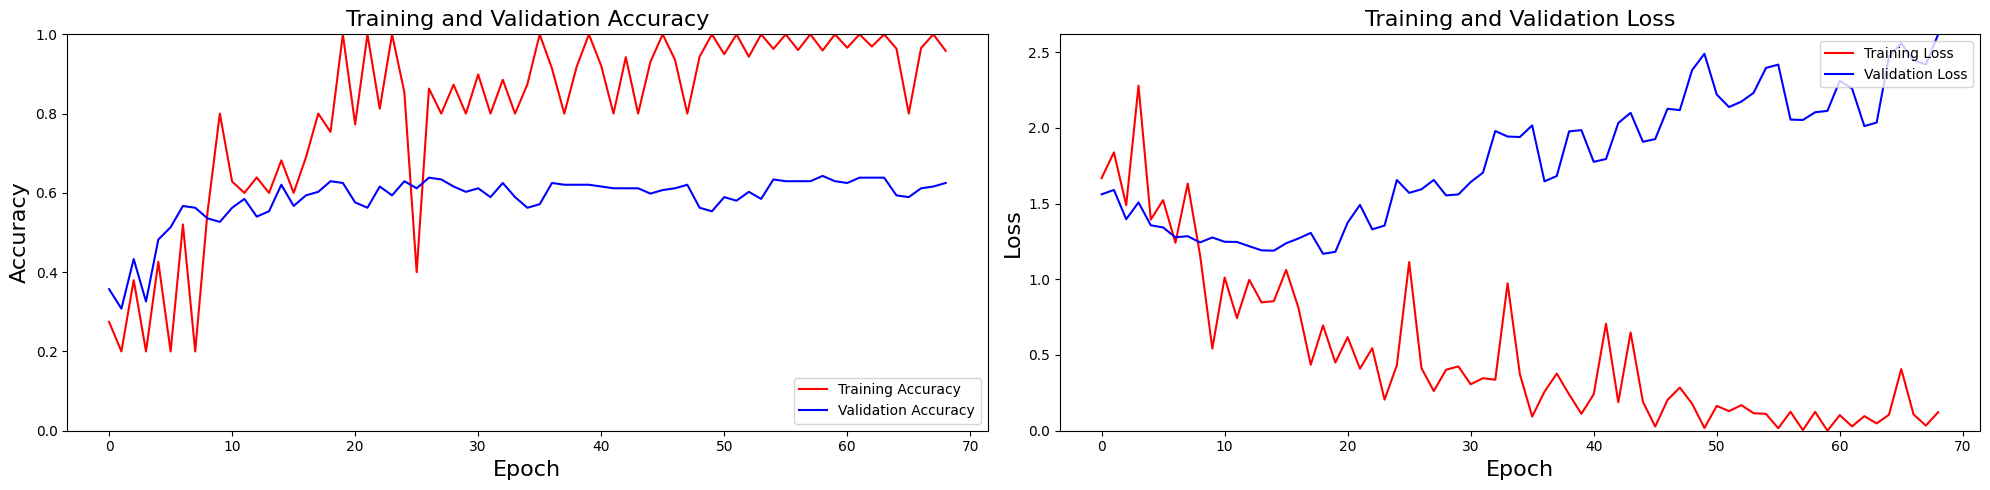

In [14]:
# y_test, y_pred = CNN_model_evaluate(model)

y_test, y_pred = CNN_model_evaluate(model, x_test, y_test, history, waste_labels)


# Confusion Matrix

In [15]:
# cm = confusion_matrix(y_test, y_pred)
# def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.OrRd):
#   if normalize:
#     cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  
#   plt.figure(figsize=(8,6))
#   plt.imshow(cm, interpolation="nearest", cmap=cmap)
#   plt.title(title)
#   plt.colorbar()
#   tick_marks = np.arange(len(classes))
#   plt.xticks(tick_marks, classes, rotation=45)
#   plt.yticks(tick_marks, classes)
#   fmt = ".2f" if normalize else "d"
#   thresh = cm.max() / 2.
#   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
#              color="white" if cm[i, j] > thresh else "black")
#   plt.tight_layout()
#   plt.ylabel("True Labels", fontweight="bold")
#   plt.xlabel("Predicted Labels", fontweight="bold")

import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.OrRd):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title, fontweight="bold")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel("True Labels", fontweight="bold", fontsize=13)
    plt.xlabel("Predicted Labels", fontweight="bold", fontsize=13)
    plt.show()




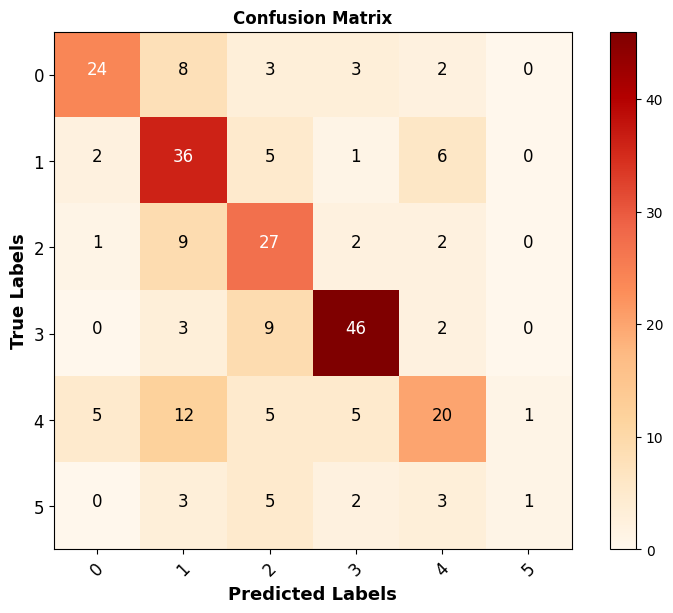

In [17]:
# plot_confusion_matrix(cm, waste_labels.keys())

cm = confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(cm, classes=list(waste_labels.values()), normalize=True)
plot_confusion_matrix(cm, classes=[str(label) for label in waste_labels.values()], normalize=False)



In [19]:
import numpy as np
import matplotlib.pyplot as plt

# If y_test is one-hot encoded, convert it back to label indices
if y_test.ndim == 2 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# Count how many samples per class
unique, counts = np.unique(y_test_labels, return_counts=True)


# Print count per class
# Reverse the dictionary: now it's {0: 'plastic', 1: 'metal', ...}
index_to_label = {v: k for k, v in waste_labels.items()}

# Use the reversed dict to get label names
label_names = [index_to_label[i] for i in unique]

# Print count per class
for label, count in zip(label_names, counts):
    print(f"{label}: {count} images")


cardboard: 40 images
glass: 50 images
metal: 41 images
paper: 60 images
plastic: 48 images
trash: 14 images


# Model Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


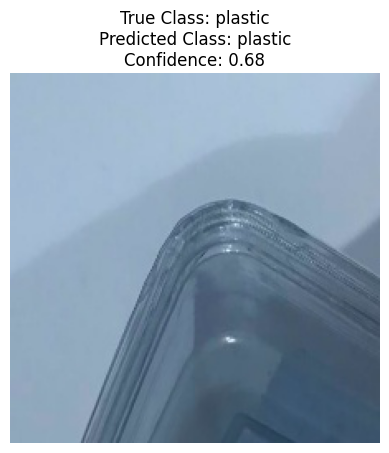

True Label: plastic
Predicted Label: plastic


In [102]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def CNN_model_test_random_image_with_true_label(model, test_folder, waste_labels, image_size=(224, 224)):
    # Get all image paths
    image_paths = [os.path.join(test_folder, img_name)
                   for img_name in os.listdir(test_folder)
                   if img_name.endswith(('.jpg', '.png', '.jpeg'))]

    if not image_paths:
        print("No images found in the test folder.")
        return None, None

    # Pick a random image
    img_path = random.choice(image_paths)
    filename = os.path.basename(img_path)

    # Extract true label from filename (e.g., "glass_01.jpg" → "glass")
    true_label = filename.split("_")[0].lower()

    # Load and preprocess image
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    p = model.predict(img_array)
    predicted_class = np.argmax(p[0])
    predicted_label = waste_labels[predicted_class]
    confidence = np.max(p[0])

    # Display
    plt.axis("off")
    plt.imshow(img)
    plt.title(f"True Class: {true_label}\n"
              f"Predicted Class: {predicted_label}\n"
              f"Confidence: {confidence:.2f}")
    plt.show()

    return true_label, predicted_label

# Example usage
test_folder = "/Users/shubhigupta/Desktop/Garbage Segregation/Smart-Garbage-Segregation-main/test_images"
waste_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

true_label, predicted_label = CNN_model_test_random_image_with_true_label(model, test_folder, waste_labels)
print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")


In [97]:
import os
import numpy as np
import cv2

def save_test_images(x_test, y_test, class_names, output_dir="test_images"):
    os.makedirs(output_dir, exist_ok=True)

    # If y_test is one-hot encoded, convert it to label indices
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    for idx, (img, label_idx) in enumerate(zip(x_test, y_test)):
        # Rescale to 0–255 if normalized
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)

        # Convert RGB to BGR for OpenCV
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # File name: e.g., paper_12.jpg
        class_name = class_names[label_idx]
        filename = f"{class_name}_{idx}.jpg"
        filepath = os.path.join(output_dir, filename)

        # Save image
        cv2.imwrite(filepath, img_bgr)

    print(f"✅ Saved {len(x_test)} images to '{output_dir}'.")

# Example usage:
# class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
# save_test_images(x_test, y_test, class_names)


In [98]:
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
save_test_images(x_test, y_test, class_names)


✅ Saved 253 images to 'test_images'.
